<a href="https://colab.research.google.com/github/sungkim11/AI_Playground/blob/main/Talking_with_AI_using_Whisper%2C_GPT_3%2C_and_Eleven_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Talking with AI using OpenAI's Whisper, OpenAI's GPT-3, and ElevenLab's Speech Synthesis

This is my attempt to combine three technologies to talk with AI. Three technologies are:
- OpenAI Whisper: automatic speech recognition (ASR) system (https://openai.com/blog/whisper/)
- OpenAI GPT-3: performs a variety of natural language tasks 
- ElevenLab's Speech Synthesis: context understanding to render human speech ultra-realistically

##1. Prequisites

Following are prerequisite for this tutorial:

- Python Package: ffmpeg
- Python Package: openai-whisper
- Python Package: openai

###1.1. Python Packages

####1.1.1. Install Python Packages

In [71]:
%%writefile requirements.txt
ffmpeg-python
openai-whisper
openai

Overwriting requirements.txt


In [72]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##2. Code

###2.1. Record audio from your microphone

This section's code to record from microphone was copied from [https://ricardodeazambuja.com/](https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb). 

Please note that you will need provide a permission to your browser to record the audio, using your computer's microphone.

####2.1.1. Import Python Packages

In [139]:
from IPython.display import HTML, Audio, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import scipy
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import whisper
import openai
import platform
import os
import requests

print('Python: ', platform.python_version())
print("google.colab: ", google.colab.__version__)
print("numpy: ", np.__version__)
print("scipy: ", scipy.__version__)
print("whisper: ", whisper.__version__)
print("requests: ", requests.__version__)

Python:  3.8.10
google.colab:  0.0.1a2
numpy:  1.21.6
scipy:  1.7.3
whisper:  20230124
requests:  2.25.1


####2.1.2. Javascripts to record audio on your browser.

In [74]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pease wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

####2.1.2. Python function to record audio on your browser.

In [75]:
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

####2.1.3. Record audio on your browser. The audio file will be saved as prompt_request.wav file.

In [77]:
audio, sr = get_audio()

In [78]:
scipy.io.wavfile.write('prompt_request.wav', sr, audio)

###2.2. Transcribe recording to text using OpenAI's Whisper

Please note that there are five available models. For more information, please refer to https://github.com/openai/whisper.

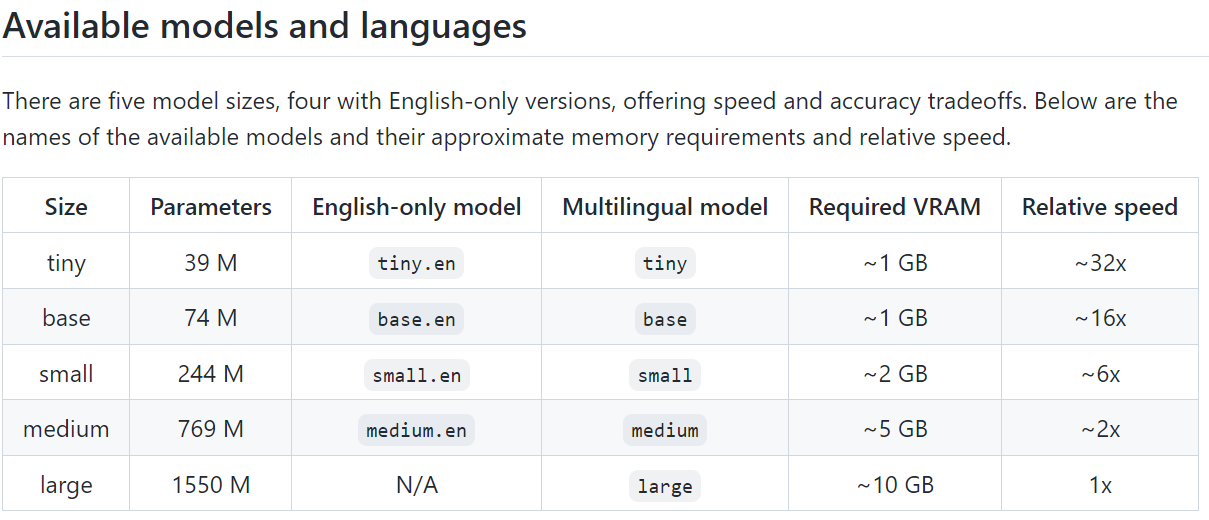



For the purpose of this exercise, I have used the medium English-only model, which will be automatically downloaded to your computer on first use.

In [79]:
model = whisper.load_model("medium.en")
result = model.transcribe("prompt_request.wav")

prompt_request = result["text"]
print(prompt_request)

 Tell me about Philadelphia campaign 1977 in less than 200 characters.


###2.3. Send recording text as a prompt for OpenAI's GPT-3 API

To talk with AI, the voice recording is transcribed to text and sent as a prompt to illicit response from OpenAI's GPT-3.

####2.3.1. Set OpenAI API Key

Please note that OpenAI's API service is not free, unlike ChatGPT demo. You will need to sign up for a service with them to get an API key, which requires payment information.

In [80]:
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [81]:
openai.api_key = os.getenv("OPENAI_API_KEY")

####2.3.2. Send a request to OpenAI's GPT-3 API.

In [82]:
response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt_request,
        temperature=.5,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

####2.3.3. Print a response from OpenAI's GPT-3 API.

In [110]:
prompt_response = response["choices"][0]["text"]
print(prompt_response)



The 1977 Philadelphia mayoral election saw Frank Rizzo win a second term, defeating challenger Ed Rendell by a narrow margin. The campaign was marked by racial tensions and accusations of police brutality.


###2.4. Transcribe text to speech using ElevenLab's API

ElevenLab's API consists of a curl request in following format. You will need to sign up for a service with them to get an API key.

curl -X POST https://api.elevenlabs.io/v1/text-to-speech/pNInz6obpgDQGcFmaJgB \
  -H 'accept: audio/mpeg' \
  -H 'xi-api-key: ELEVENLABS_API_KEY \
  -H 'Content-Type: application/json' \
  -d '{"text":"The 1977 Philadelphia mayoral election saw Frank Rizzo win a second term, defeating challenger Ed Rendell by a narrow margin. The campaign was marked by racial tensions and accusations of police brutality."}' \
  --output prompt_response.mp3

####2.4.1. Set ElevenLabs's API Key

In [134]:
ELEVENLABS_API_KEY = ELEVENLABS_API_KEY

####2.4.2. Send a request using curl.

In [135]:
headers = {
    'accept': 'audio/mpeg',
    'xi-api-key': ELEVENLABS_API_KEY,
    'Content-Type': 'application/json',
}

json_data = {
    'text': prompt_response,
}

response = requests.post('https://api.elevenlabs.io/v1/text-to-speech/pNInz6obpgDQGcFmaJgB', headers=headers, json=json_data)

with open('prompt_response.mp3', 'wb') as f:
    f.write(response.content)

####2.4.3. Play the speech file, saved in .mp3 format.

In [136]:
prompt_response_speech = "prompt_response.mp3"
display(Audio(prompt_response_speech, autoplay=True))